<a href="https://colab.research.google.com/github/nasy-sr/Project-Tugas-Kelompok-Neural-Networks/blob/notebooks/Dataset4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    classification_report, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score
)

import tensorflow as tf

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

file_path = "/content/drive/MyDrive/Dataset 4/hotel_bookings.csv"
df = pd.read_csv(file_path)

print("Loaded:", file_path)
display(df.head())
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

Mounted at /content/drive
Loaded: /content/drive/MyDrive/Dataset 4/hotel_bookings.csv


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


Shape: (119390, 32)

Columns: ['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date']


In [ ]:
TARGET = "is_canceled"
drop_cols = ["agent", "company", "reservation_status_date"]

df = df.drop(columns=drop_cols, errors="ignore")

df = df.dropna(subset=[TARGET])

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

print("\nDistribusi target (is_canceled):")
print(y.value_counts())


Distribusi target (is_canceled):
is_canceled
0    75166
1    44224
Name: count, dtype: int64


In [ ]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("\nNumerik:", num_cols)
print("Kategorikal:", cat_cols)


Numerik: ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']
Kategorikal: ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']


In [ ]:
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=SEED,
    stratify=y
)

X_train_p = preprocess.fit_transform(X_train)
X_test_p  = preprocess.transform(X_test)

X_train_p = X_train_p.astype(np.float32)
X_test_p  = X_test_p.astype(np.float32)

n_features = X_train_p.shape[1]
print("\nn_features:", n_features)


n_features: 246


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_features,)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        31,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,937 (156.00 KB)

 Trainable params: 39,937 (156.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

history = model.fit(
    X_train_p, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9498 - auc: 0.9814 - loss: 0.1145 - val_accuracy: 0.9999 - val_auc: 1.0000 - val_loss: 3.0624e-04
Epoch 2/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9998 - auc: 1.0000 - loss: 6.5482e-04 - val_accuracy: 0.9999 - val_auc: 1.0000 - val_loss: 1.2985e-04
Epoch 3/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9999 - auc: 1.0000 - loss: 2.8223e-04 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 1.6243e-06
Epoch 4/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 8.9821e-05 - val_accuracy: 0.9996 - val_auc: 0.9998 - val_loss: 0.0025
Epoch 5/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.0422e-04 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 1.1580e-05
Epoch 6/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.5157e-04 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss:

In [ ]:
y_prob = model.predict(X_test_p).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

1120/1120 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Confusion Matrix:
[[22550     0]
 [    0 13267]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     22550
           1     1.0000    1.0000    1.0000     13267

    accuracy                         1.0000     35817
   macro avg     1.0000    1.0000    1.0000     35817
weighted avg     1.0000    1.0000    1.0000     35817



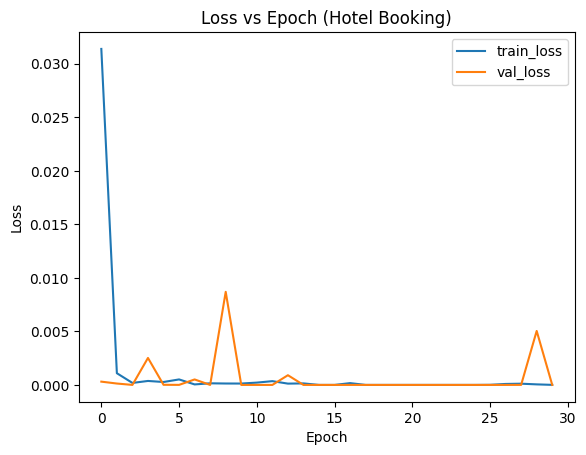

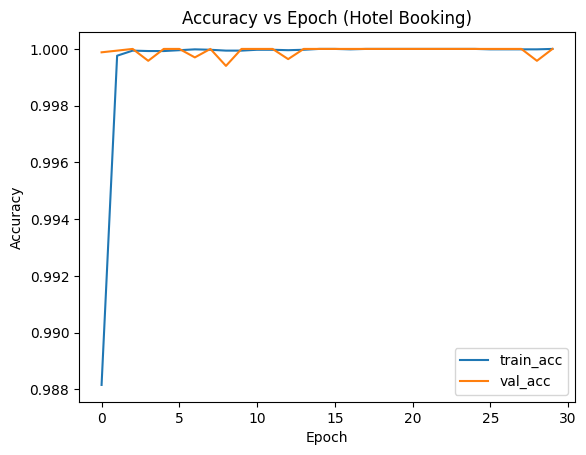

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss vs Epoch (Hotel Booking)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy vs Epoch (Hotel Booking)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()